# Street View House Numbers (SVHN) - Reconhecimento de números

## Setup

### Pacotes gerais

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import patches
from IPython import display

import os
import time
import h5py
import json
import pprint
import random
import pkgutil

import cv2
import numpy as np

from skimage import transform

/home/adriano/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Setup para Google Colab

In [2]:
if pkgutil.find_loader('torch') is None:
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

    accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

### Pacotes do Pytorch

In [3]:
import torch
import torchvision

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Preparação das anotações

O dataset  [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) contém os dados já separados em pastas de treinamento e teste, com anotações no formato *.mat*. Para facilitar o acesso a cada anotação, será realizada a conversão dessa estrutura para o formato JSON.

In [4]:
svhn_dataset_folder = '/home/adriano/Documentos/Mestrado/IA376F_Redes_Neurais_Leitura_Robusta/data/SVHN'

In [5]:
def svhnMat2Json(mat_filepath):
    bbox_attr = ['height', 'width', 'left', 'top', 'label']

    h5f = h5py.File(mat_filepath, 'r')

    digitStruct = h5f['digitStruct']
    bbox = digitStruct['bbox']
    name = digitStruct['name']

    file_dict = dict()
    for idx in range(bbox.size):
        file_entry_list = list()
        file_name = ''.join([chr(i[0]) for i in h5f[name[idx][0]]])

        file_entry_size = h5f[bbox[idx][0]][bbox_attr[0]].size
        if file_entry_size == 1:
            entry_dict = dict()
            for attr in bbox_attr:
                entry_dict[attr] = int(h5f[bbox[idx][0]][attr][0][0])
            file_entry_list.append(entry_dict)
        else:
            for entry in range(file_entry_size):
                entry_dict = dict()
                for attr in bbox_attr:
                    entry_dict[attr] = int(h5f[h5f[bbox[idx][0]][attr][entry][0]][0][0])
                file_entry_list.append(entry_dict)

        file_dict[file_name] = file_entry_list

    json_filepath = mat_filepath.replace('.mat', '.json')

    json_str = json.dumps(file_dict, indent=4, separators=(',', ': '))
    f = open(json_filepath, 'w')
    f.write(json_str)
    f.close()

In [6]:
dataset_folder_train = os.path.join(svhn_dataset_folder, 'train')
svhn_mat_filepath_train = os.path.join(dataset_folder_train, 'digitStruct.mat')

if not os.path.isfile(svhn_mat_filepath_train.replace('.mat', '.json')):
    svhnMat2Json(svhn_mat_filepath_train)

In [7]:
dataset_folder_test = os.path.join(svhn_dataset_folder, 'test')
svhn_mat_filepath_test = os.path.join(dataset_folder_test, 'digitStruct.mat')

if not os.path.isfile(svhn_mat_filepath_test.replace('.mat', '.json')):
    svhnMat2Json(svhn_mat_filepath_test)

## Classe Dataset

In [8]:
num_digits = 5

In [9]:
class SVHNDataset(torch.utils.data.Dataset):
    def __init__(self, rootdir, transforms=None, data_split=None, num_digits=num_digits):
        self.transforms = transforms

        # Get list of images
        image_list = [file_name for file_name in os.listdir(rootdir) if file_name.endswith('.png')]

        # Update list of images to desired range
        if isinstance(data_split, int):
            if data_split > 0:
                image_list = image_list[:data_split]
            else:
                image_list = image_list[data_split:]
        elif isinstance(data_split, float):
            if data_split > 0.0:
                image_list = image_list[:int(np.ceil(len(image_list) * data_split))]
            else:
                image_list = image_list[int(np.ceil(len(image_list) * data_split)):]

        # Read bounding box and label data
        image_data = None
        for entry in os.listdir(rootdir):
            if entry.endswith('.json'):
                image_data_obj = open(os.path.join(rootdir, entry), 'r')
                image_data = json.load(image_data_obj)
                image_data_obj.close()
                break

        # Make list of image paths and merge bounding boxes
        self.image_path_list = list()
        self.image_data_list = list()
        for image_name in image_list:
            diff_num_digits = num_digits - len(image_data[image_name])
            if diff_num_digits < 0:
                continue

            self.image_path_list.append(os.path.join(rootdir, image_name))

            label_value = [len(image_data[image_name])]

            entry = image_data[image_name][0]
            label_value.append(entry['label'] if entry['label'] != 10 else 0)

            bbox_col_min = entry['left']
            bbox_row_min = entry['top']
            bbox_col_max = entry['left'] + entry['width']
            bbox_row_max = entry['top'] + entry['height']
            for idx in range(1, len(image_data[image_name])):
                entry = image_data[image_name][idx]
                label_value.append(entry['label'] if entry['label'] != 10 else 0)

                bbox_col = entry['left'] + entry['width']
                bbox_row = entry['top'] + entry['height']

                if bbox_col_min > entry['left']:
                    bbox_col_min = entry['left']
                if bbox_row_min > entry['top']:
                    bbox_row_min = entry['top']
                if bbox_col_max < bbox_col:
                    bbox_col_max = bbox_col
                if bbox_row_max < bbox_row:
                    bbox_row_max = bbox_row

            label_value = label_value + ([10] * diff_num_digits)

            self.image_data_list.append(dict(bbox=[bbox_col_min, bbox_row_min,
                                                   (bbox_col_max - bbox_col_min),
                                                   (bbox_row_max - bbox_row_min)],
                                             label=label_value))

    def __len__(self):
        return len(self.image_path_list)

    def __getitem__(self, index):
        if type(index) is int:
            fp = self.image_path_list[index]
            fd = self.image_data_list[index]
        else:
            fp = self.image_path_list[index][0]
            fd = self.image_data_list[index][0]

        img = cv2.cvtColor(cv2.imread(fp, cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR).astype(np.float32)/255, cv2.COLOR_BGR2RGB)

        sample = {'image': img, 'bbox': fd['bbox'], 'label': fd['label']}

        if self.transforms:
            sample = self.transforms(sample)

        return sample

## Classes de Transformações

In [10]:
# Transform classes adapted from PyTorch Data Loading tutorial:
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

class FixBBox(object):
    """Fix bounding boxes with dimensions beyond image limits."""

    def __call__(self, sample):
        h, w = sample['image'].shape[:2]
        bbox = sample['bbox']
        
        if (bbox[0] + bbox[2]) > w:
            bbox[2] = w - bbox[0]

        if (bbox[1] + bbox[3]) > h:
            bbox[3] = h - bbox[1]

        return {'image': sample['image'], 'bbox': bbox, 'label': sample['label']}


class CropBBox(object):
    """Crop the image based on bounding box.

    Args:
        bbox_perc (float/tuple): Percentage of bounding box height-width.
    """

    def __init__(self, bbox_perc=1.3):
        assert isinstance(bbox_perc, (float, tuple))
        self.bbox_perc = bbox_perc

    def __call__(self, sample):
        image = sample['image']
        bbox = sample['bbox']

        h, w = image.shape[:2]

        if isinstance(self.bbox_perc, float):
            new_h = min(h, int(round(bbox[3] * self.bbox_perc)))
            new_w = min(w, int(round(bbox[2] * self.bbox_perc)))
        else:
            new_h = min(h, int(round(bbox[3] * self.bbox_perc[0])))
            new_w = min(w, int(round(bbox[2] * self.bbox_perc[1])))

        if new_w > bbox[2]:
            delta_bbox_w = (new_w - bbox[2]) // 2
            start_w = max(0, bbox[0] - delta_bbox_w)
            delta_start_w = w - (start_w + new_w)

            if delta_start_w < 0:
                start_w += delta_start_w
        else:
            start_w = 0

        if new_h > bbox[3]:
            delta_bbox_h = (new_h - bbox[3]) // 2
            start_h = max(0, bbox[1] - delta_bbox_h)
            delta_start_h = h - (start_h + new_h)

            if delta_start_h < 0:
                start_h += delta_start_h
        else:
            start_h = 0

        image = image[start_h:(start_h + new_h),start_w:(start_w + new_w)]

        bbox = [bbox[0] - start_w,
                bbox[1] - start_h,
                bbox[2],
                bbox[3]]

        return {'image': image, 'bbox': bbox, 'label': sample['label']}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple): Desired output size.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, tuple)
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']
        bbox = sample['bbox']

        h, w = image.shape[:2]
        new_h, new_w = int(self.output_size[0]), int(self.output_size[1])

        ratio_w = new_w / w
        ratio_h = new_h / h
        image = transform.resize(image, (new_h, new_w))

        bbox = [int(round(bbox[0] * ratio_w)),
                int(round(bbox[1] * ratio_h)),
                int(round(bbox[2] * ratio_w)),
                int(round(bbox[3] * ratio_h))]

        return {'image': image, 'bbox': bbox, 'label': sample['label']}


class RandomCrop(object):
    """Crop the image in a sample to a given size.

    Args:
        output_size (tuple): Desired output size.
    """

    def __init__(self, output_size, protect_bbox=True):
        assert isinstance(output_size, tuple)
        self.output_size = output_size
        self.protect_bbox = protect_bbox

    def __call__(self, sample):
        image = sample['image']
        bbox = sample['bbox']

        h, w = image.shape[:2]
        new_h, new_w = int(self.output_size[0]), int(self.output_size[1])
        assert h > new_h, 'Crop height is greater than image height'
        assert w > new_w, 'Crop width is greater than image width'

        if self.protect_bbox:
            delta_bbox_w = new_w - bbox[2]
            delta_bbox_h = new_h - bbox[3]

            if delta_bbox_w > 0:
                try:
                    start_w = random.randint(max(0, bbox[0] - delta_bbox_w), min(bbox[0], w - new_w))
                except ValueError:
                    start_w = 0
            else:
                start_w = random.randint(bbox[0], bbox[0] - delta_bbox_w)

            if delta_bbox_h > 0:
                try:
                    start_h = random.randint(max(0, bbox[1] - delta_bbox_h), min(bbox[1], h - new_h))
                except ValueError:
                    start_h = 0
            else:
                start_h = random.randint(bbox[1], bbox[1] - delta_bbox_h)

        else:
            start_w = random.randint(0, w - new_w)
            start_h = random.randint(0, h - new_h)

        image = image[start_h:(start_h + new_h),start_w:(start_w + new_w)]

        start_bbox_w = bbox[0] - start_w
        start_bbox_h = bbox[1] - start_h
        end_bbox_w = bbox[2] + start_bbox_w
        end_bbox_h = bbox[3] + start_bbox_h
        start_bbox_w = max(0, start_bbox_w)
        start_bbox_h = max(0, start_bbox_h)

        bbox = [start_bbox_w,
                start_bbox_h,
                min(new_w, end_bbox_w) - start_bbox_w,
                min(new_h, end_bbox_h) - start_bbox_h]

        return {'image': image, 'bbox': bbox, 'label': sample['label']}


class Normalize(object):
    """Normalize image and bounding box arrays."""

    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], reverse=False):
        self.mean = np.array([[mean]])
        self.std = np.array([[std]])
        self.reverse = reverse

    def __call__(self, sample):
        image = sample['image']
        bbox = sample['bbox']

        h, w = image.shape[:2]

        if self.reverse:
            image = image * self.std + self.mean

            bbox = np.array([int(round(bbox[0] * w)),
                             int(round(bbox[1] * h)),
                             int(round(bbox[2] * w)),
                             int(round(bbox[3] * h))])
        else:
            image = (image - self.mean) / self.std

            bbox = np.array([bbox[0] / w,
                             bbox[1] / h,
                             bbox[2] / w,
                             bbox[3] / h])

        label = np.array(sample['label'])

        return {'image': sample['image'],
                'bbox': bbox,
                'label': label}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = sample['image'].transpose((2, 0, 1))

        return {'image': torch.from_numpy(image).float(),
                'bbox': torch.from_numpy(sample['bbox']).float(),
                'label': torch.from_numpy(sample['label']).long()}


class ToNumpy(object):
    """Convert tensors in sample to Numpy Arrays."""

    def __call__(self, sample):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        return {'image': sample['image'].numpy().transpose((1, 2, 0)),
                'bbox': sample['bbox'].numpy(),
                'label': sample['label'].numpy()}

## Criação de Datasets para Treinamento, Validação e Teste

In [11]:
transform_svhn = torchvision.transforms.Compose([
    FixBBox(),
    CropBBox(),
    Rescale((64, 64)),
    RandomCrop((54, 54)),
    Normalize(),
    ToTensor()
])

dataset_train = SVHNDataset(dataset_folder_train, transforms=transform_svhn, data_split=0.7)
dataset_valid = SVHNDataset(dataset_folder_train, transforms=transform_svhn, data_split=-0.3)
dataset_test = SVHNDataset(dataset_folder_test, transforms=transform_svhn)

### Total de amostras por número de dígitos e exemplos

In [12]:
def countClass(dataset_obj):
    class_count_dict = dict()
    for entry in dataset_obj.image_data_list:
        class_count_dict[entry['label'][0]] = class_count_dict.get(entry['label'][0], 0) + 1

    return class_count_dict

In [13]:
def vizNumbers(dataset, image_refs):
    num_cols = 4

    if type(image_refs) is range:
        image_ids = list(image_refs)
    elif type(image_refs) is list:
        image_ids = image_refs
    else:
        image_ids = [image_refs]

    fig = plt.figure(figsize=(20, 20))

    num_imgs = len(image_ids)
    num_rows = int(np.ceil(num_imgs/num_cols))

    viz_transforms = torchvision.transforms.Compose([
        ToNumpy(),
        Normalize(reverse=True)
    ])

    for idx in range(num_imgs):
        img_id = image_ids[idx]
        entry = viz_transforms(dataset[img_id])

        ax = fig.add_subplot(num_rows, num_cols, 1 + idx)
        ax.imshow(entry['image'])

        h, w = entry['image'].shape[:2]

        ax.add_patch(patches.Rectangle(entry['bbox'][:2], entry['bbox'][2], entry['bbox'][3],
                                       fill=False, edgecolor='blue', lw=2))

        ax.set_title(f'{entry["label"]} - {entry["image"].shape}')
        ax.axis('off')
    plt.show()

In [14]:
def vizNumbersProblem(dataset, image_ids):
    viz_transforms = torchvision.transforms.Compose([
        ToNumpy(),
        Normalize(reverse=True)
    ])

    #for idx in range(len(dataset)):
    for idx in image_ids:
        entry = viz_transforms(dataset[idx])
        h, w = entry['image'].shape[:2]
        if (h == 54) and (w == 54):
            continue

        print(f'{idx} - ({h},{w})')

#### Treinamento

In [15]:
train_sample_count = countClass(dataset_train)
pprint.pprint(train_sample_count)

{1: 3540, 2: 12738, 3: 6071, 4: 1026, 5: 6}


/home/adriano/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


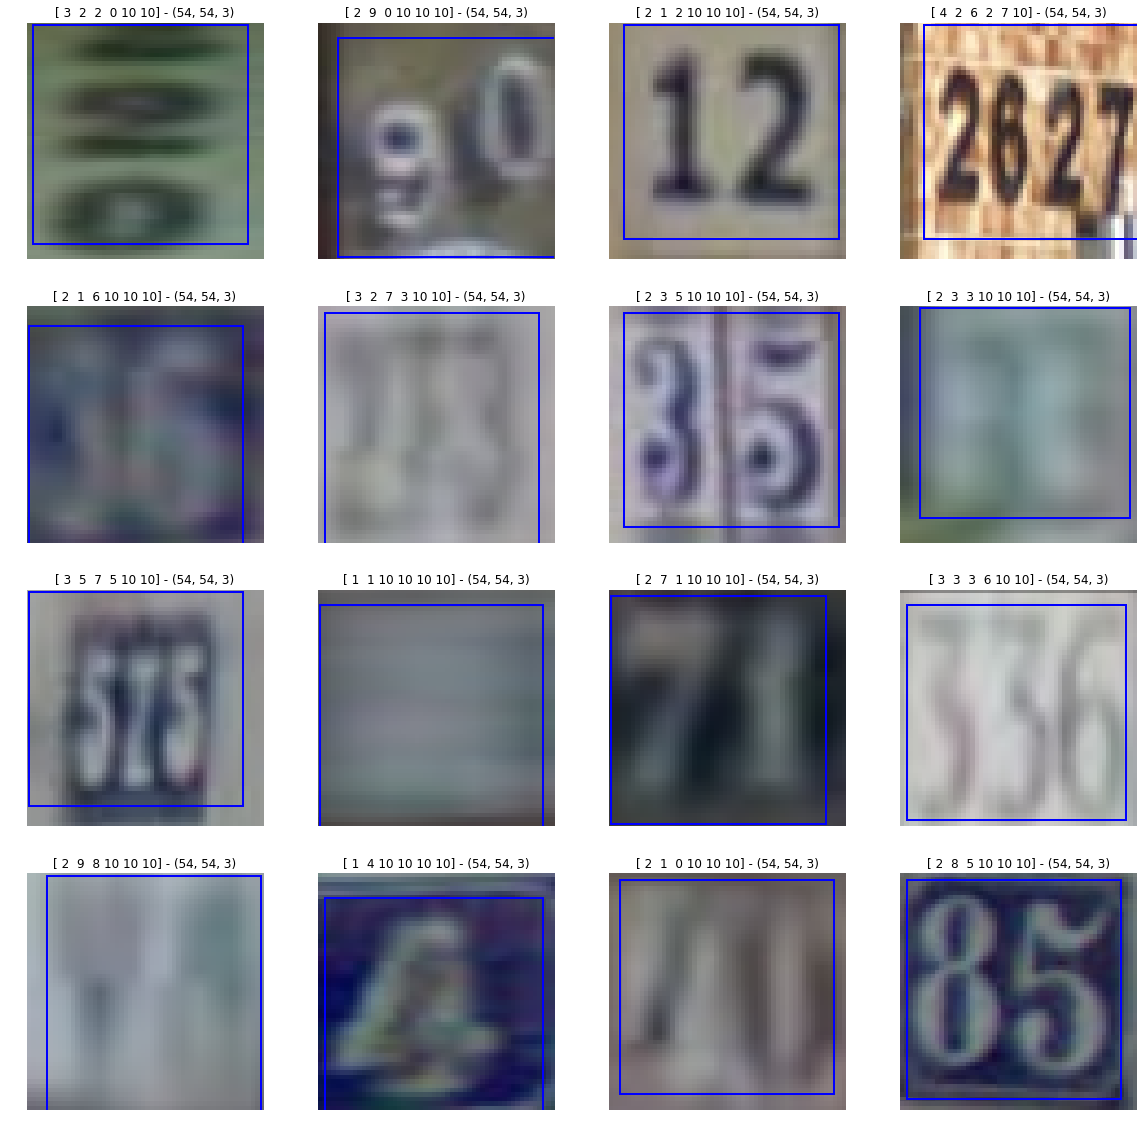

In [16]:
vizNumbers(dataset_train, range(16))

#### Validação

In [17]:
valid_sample_count = countClass(dataset_valid)
pprint.pprint(valid_sample_count)

{1: 1597, 2: 5392, 3: 2620, 4: 408, 5: 3}


/home/adriano/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


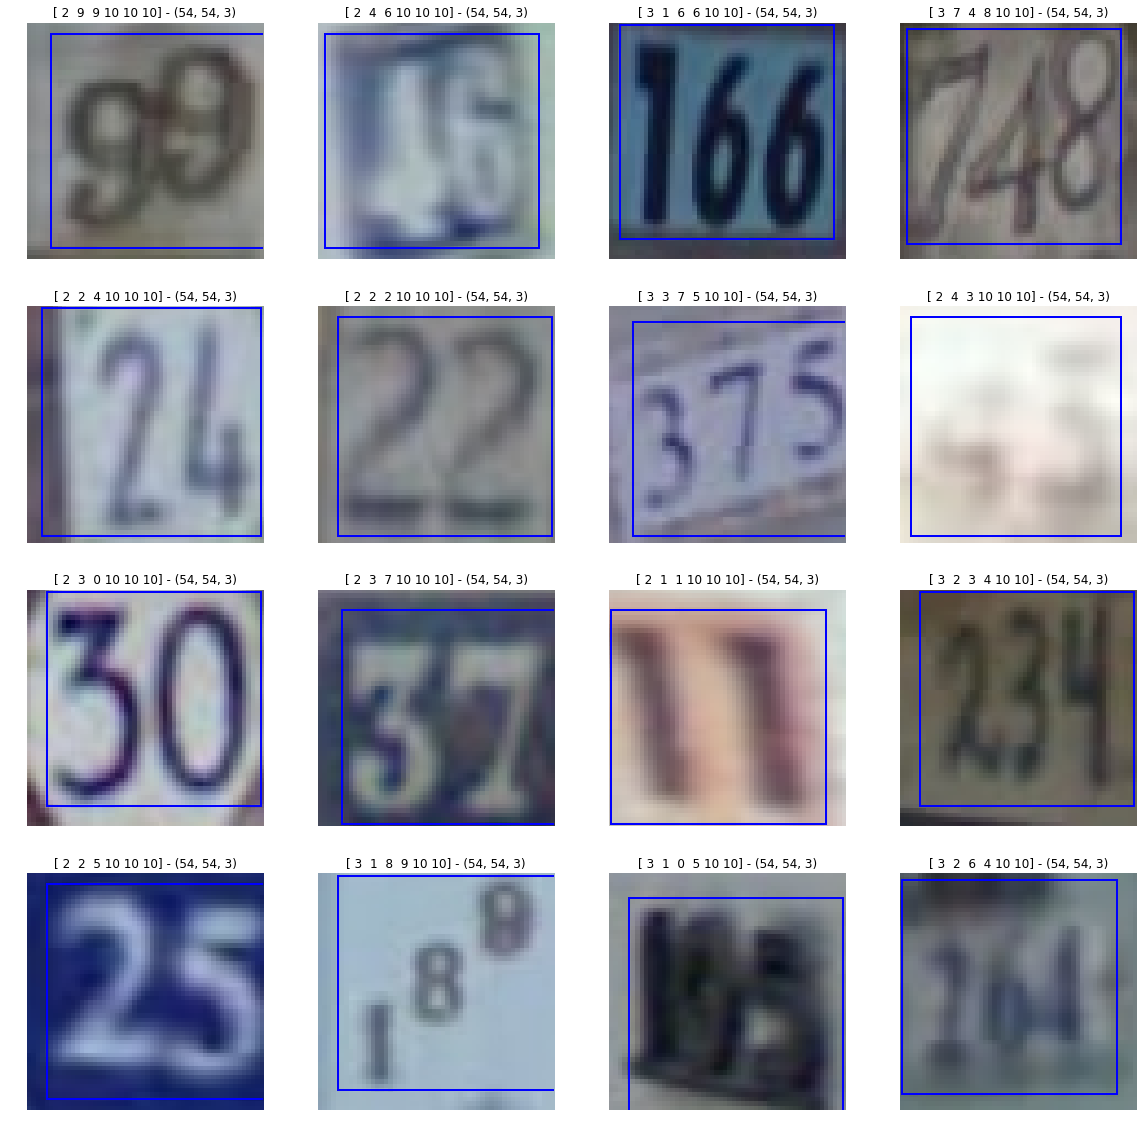

In [18]:
vizNumbers(dataset_valid, range(16))

#### Teste

In [19]:
test_sample_count = countClass(dataset_test)
pprint.pprint(test_sample_count)

{1: 2483, 2: 8356, 3: 2081, 4: 146, 5: 2}


/home/adriano/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


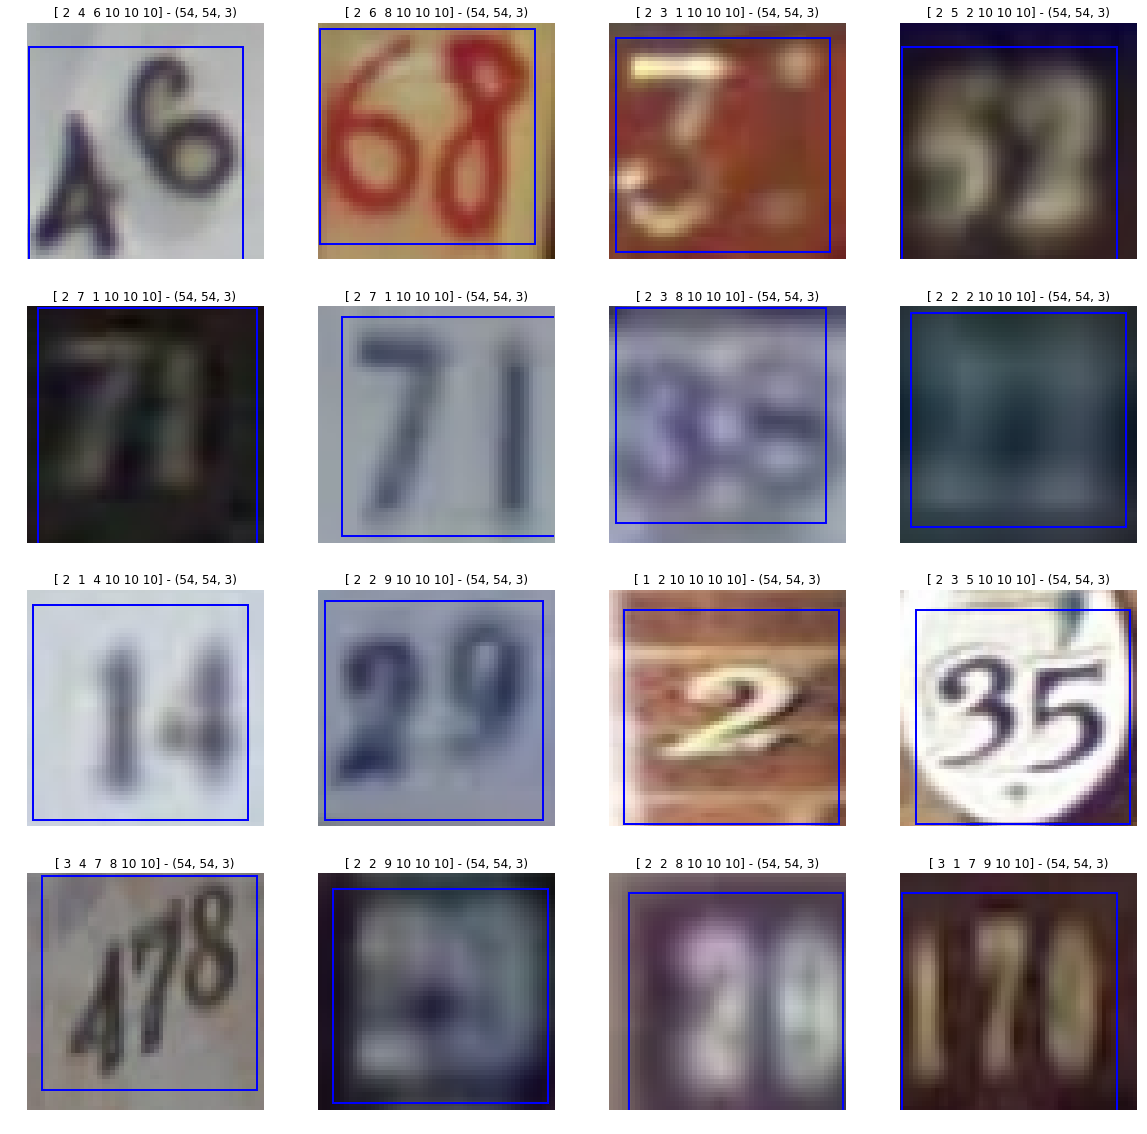

In [20]:
vizNumbers(dataset_test, range(16))

## Dataloaders para treinamento

In [21]:
batch_size = 8

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=0)

## Definição do modelo (rede neural)

In [22]:
# Model adapted from https://github.com/potterhsu/SVHNClassifier-PyTorch/blob/master/model.py

class PotterHsuModel(torch.nn.Module):
    def __init__(self):
        super(PotterHsuModel, self).__init__()

        out_channels_list = [48, 64, 128, 160, 192, 192, 192, 192]

        self.in_channels = 3

        features_layers = list()
        for idx in range(len(out_channels_list)):
            features_layers.append(self._make_conv_layer(out_channels_list[idx], (2 - idx%2)))

        self._features = torch.nn.Sequential(*features_layers)

        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(192 * 7 * 7, 3072),
            torch.nn.ReLU(),
            torch.nn.Linear(3072, 3072),
            torch.nn.ReLU()
        )

        self._digit_length = torch.nn.Linear(3072, 7)

        self._digit1 = torch.nn.Linear(3072, 11)
        self._digit2 = torch.nn.Linear(3072, 11)
        self._digit3 = torch.nn.Linear(3072, 11)
        self._digit4 = torch.nn.Linear(3072, 11)
        self._digit5 = torch.nn.Linear(3072, 11)

    def _make_conv_layer(self, out_channels, mp_stride):
        layers = [
            torch.nn.Conv2d(in_channels=self.in_channels, out_channels=out_channels, kernel_size=5, padding=2),
            torch.nn.BatchNorm2d(num_features=out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=mp_stride, padding=1),
            torch.nn.Dropout(0.2)
        ]

        self.in_channels = out_channels

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self._features(x)
        x = x.view(x.size(0), 192 * 7 * 7)
        x = self._classifier(x)

        length_logits = self._digit_length(x)

        digits_logits = [
            self._digit1(x),
            self._digit2(x),
            self._digit3(x),
            self._digit4(x),
            self._digit5(x)
        ]

        return length_logits, digits_logits

### Teste do modelo

In [23]:
model = PotterHsuModel()
model.to(device)

PotterHsuModel(
  (_features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.2)
    )
    (1): Sequential(
      (0): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.2)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Dr

In [24]:
dataiter = iter(dataloader_train)
samples = dataiter.next()
print(f'Dimensão da entrada: {samples["image"].shape}')
print(f'Dimensão do label: {samples["label"].shape}')

Dimensão da entrada: torch.Size([8, 3, 54, 54])
Dimensão do label: torch.Size([8, 6])


/home/adriano/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [25]:
samples_output = model.forward(samples['image'].to(device))
print('Dimensões das saídas do modelo:')
print(f'    length_logits: {samples_output[0].shape}')
for idx in range(len(samples_output[1])):
    print(f'    digit_logits({idx+1}): {samples_output[1][idx].shape}')

Dimensões das saídas do modelo:
    length_logits: torch.Size([8, 7])
    digit_logits(1): torch.Size([8, 11])
    digit_logits(2): torch.Size([8, 11])
    digit_logits(3): torch.Size([8, 11])
    digit_logits(4): torch.Size([8, 11])
    digit_logits(5): torch.Size([8, 11])


## Definição da Função de Perda

In [26]:
# Method adapted from https://github.com/potterhsu/SVHNClassifier-PyTorch/blob/master/train.py

class PotterHsuLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.cel = torch.nn.CrossEntropyLoss()

    def forward(self, length_logits, digits_logits, length_labels, digits_labels):
        length_loss = self.cel(length_logits, length_labels)
        digit1_loss = self.cel(digits_logits[0], digits_labels[:,0])
        digit2_loss = self.cel(digits_logits[1], digits_labels[:,1])
        digit3_loss = self.cel(digits_logits[2], digits_labels[:,2])
        digit4_loss = self.cel(digits_logits[3], digits_labels[:,3])
        digit5_loss = self.cel(digits_logits[4], digits_labels[:,4])

        return length_loss + digit1_loss + digit2_loss + digit3_loss + digit4_loss + digit5_loss

### Teste da função

In [27]:
crit = PotterHsuLoss()
loss_test = crit(samples_output[0], samples_output[1],
                 torch.autograd.Variable(samples['label'][:,0]).to(device),
                 torch.autograd.Variable(samples['label'][:,1:]).to(device))
#loss_test = crit(samples_output, torch.autograd.Variable(samples['label']).to(device))
loss_test_value = loss_test.cpu().item()
print(f'Valor da função de perda customizada: {loss_test_value}')

Valor da função de perda customizada: 13.991607666015625


## Treinamento

In [28]:
n_epochs = 20

optm = torch.optim.Adam(params=model.parameters(), lr=1.e-4, betas=(0.9, 0.999))
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)

In [29]:
num_train_samples = len(dataloader_train.dataset)
num_train_batches = num_train_samples // batch_size
num_valid_samples = len(dataloader_valid.dataset)
num_valid_batches = num_valid_samples // batch_size

batch_print_size = 10

epoch_train_loss_history = list()
epoch_valid_loss_history = list()
print('Start training for {} epochs'.format(n_epochs))

try:
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        train_t0 = time.time()
        epoch_train_loss = 0.0
        running_loss = 0.0

        for i, samples in enumerate(dataloader_train):
            # get the inputs
            images = samples['image'].to(device)
            labels = torch.autograd.Variable(samples['label']).to(device)

            # zero the parameter gradients
            optm.zero_grad()

            # forward + backward + optimize
            outputs = model(images)
            loss = crit(outputs[0], outputs[1], labels[:,0], labels[:,1:])
            loss_value = loss.cpu().item()
            loss.backward()
            optm.step()

            # Update loss totals
            running_loss += loss_value
            epoch_train_loss += loss_value

            # print statistics
            if i % batch_print_size == (batch_print_size - 1):
                print(f'Train batch {i+1}/{num_train_batches}: loss {running_loss/batch_print_size}', end='\r')
                running_loss = 0.0

        epoch_train_loss /= num_train_samples
        train_t1 = time.time() - train_t0


        valid_t0 = time.time()
        epoch_valid_loss = 0.0
        running_loss = 0.0

        with torch.no_grad():
            for i, samples in enumerate(dataloader_valid):
                # get the inputs
                images = samples['image'].to(device)
                labels = torch.autograd.Variable(samples['label']).to(device)

                # forward
                outputs = model(images)
                loss = crit(outputs[0], outputs[1], labels[:,0], labels[:,1:])
                loss_value = loss.cpu().item()

                # Update loss totals
                running_loss += loss_value
                epoch_valid_loss += loss_value

                # print statistics
                if i % batch_print_size == (batch_print_size - 1):
                    print(f'Valid batch {i+1}/{num_valid_batches}: loss {running_loss/batch_print_size}', end='\r')
                    running_loss = 0.0

        epoch_valid_loss /= num_valid_samples
        valid_t1 = time.time() - valid_t0

        epoch_train_loss_history.append(epoch_train_loss)
        epoch_valid_loss_history.append(epoch_valid_loss)

        print(f'Epoch {epoch:3d} > train: T={train_t1:5.1f}s | loss={epoch_train_loss}  valid: T={valid_t1:5.1f}s | loss={epoch_valid_loss}')

    print('Finished Training')
except KeyboardInterrupt:
    print('Finished by user')

Start training for 20 epochs


/home/adriano/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Epoch   0 > train: T=405.6s | loss=0.6503140853910633  valid: T= 45.6s | loss=0.48288435313753975
Epoch   1 > train: T=406.9s | loss=0.39356064559619924  valid: T= 45.5s | loss=0.3201188638836086
Epoch   2 > train: T=406.1s | loss=0.282910652102725  valid: T= 45.0s | loss=0.2556481357582077
Epoch   3 > train: T=405.4s | loss=0.22907027639478916  valid: T= 45.1s | loss=0.2379578091732102
Epoch   4 > train: T=404.1s | loss=0.1942776930413888  valid: T= 45.0s | loss=0.19575772574561798
Epoch   5 > train: T=403.9s | loss=0.172647782055831  valid: T= 46.2s | loss=0.18098948962406483
Epoch   6 > train: T=404.3s | loss=0.15085040530578078  valid: T= 45.6s | loss=0.16849620444421282
Epoch   7 > train: T=402.1s | loss=0.13939800473763928  valid: T= 45.1s | loss=0.1594814931256269
Epoch   8 > train: T=402.1s | loss=0.12614805937083579  valid: T= 45.1s | loss=0.15617183353231398
Epoch   9 > train: T=401.9s | loss=0.11471088559992411  valid: T= 45.1s | loss=0.1644160771257283
Epoch  10 > train: T=

### Evolução do treinamento

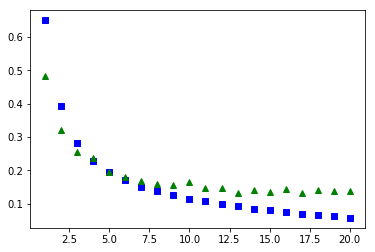

In [30]:
a_epochs = np.arange(1, 1 + len(epoch_train_loss_history))
plt.plot(a_epochs, epoch_train_loss_history, 'bs', a_epochs, epoch_valid_loss_history, 'g^')
plt.show()

## Resultados

### Cálculo da acurácia no conjunto de teste

Conforme apontado no paper, a acurácia é calculada sobre acertos completos (acerto do comprimento e de todos os dígitos dentro do comprimento).

In [31]:
pred_length_list = list()
pred_digit_list = list()

label_length_list = list()
label_digit_list = list()

for idx in range(num_digits):
    pred_digit_list.append(list())
    label_digit_list.append(list())

with torch.no_grad():
    test_loss = 0.0

    for i, samples in enumerate(dataloader_test):
        # get the inputs
        inputs = samples['image'].to(device)
        labels = samples['label']

        # forward
        outputs = model(inputs)

        pred_length_list.append(outputs[0])
        label_length_list.append(labels[:,0])

        for idx in range(num_digits):
            pred_digit_list[idx].append(outputs[1][idx])
            label_digit_list[idx].append(labels[:,idx+1])

/home/adriano/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [32]:
test_length_prob_pred = torch.cat(tuple(pred_length_list), 0)
print(f'Dimensão do tensor de log-prob de comprimentos preditos: {test_length_prob_pred.shape}')

test_digit_prob_pred = list()
for idx in range(num_digits):
    test_digit_prob_pred.append(torch.cat(tuple(pred_digit_list[idx]), 0))
    print(f'Dimensão do tensor de log-prob do dígito {idx+1} preditos: {test_digit_prob_pred[idx].shape}')

Dimensão do tensor de log-prob de comprimentos preditos: torch.Size([13068, 7])
Dimensão do tensor de log-prob do dígito 1 preditos: torch.Size([13068, 11])
Dimensão do tensor de log-prob do dígito 2 preditos: torch.Size([13068, 11])
Dimensão do tensor de log-prob do dígito 3 preditos: torch.Size([13068, 11])
Dimensão do tensor de log-prob do dígito 4 preditos: torch.Size([13068, 11])
Dimensão do tensor de log-prob do dígito 5 preditos: torch.Size([13068, 11])


In [33]:
test_length_pred = np.argmax(test_length_prob_pred.cpu().numpy(), axis=1)
print(f'Dimensão do array predito para o comprimento: {test_length_pred.shape}')

test_digit_pred = list()
for idx in range(num_digits):
    test_digit_pred.append(np.argmax(test_digit_prob_pred[idx].cpu().numpy(), axis=1))
    print(f'Dimensão do array predito para o dígito {idx+1}: {test_digit_pred[idx].shape}')

Dimensão do array predito para o comprimento: (13068,)
Dimensão do array predito para o dígito 1: (13068,)
Dimensão do array predito para o dígito 2: (13068,)
Dimensão do array predito para o dígito 3: (13068,)
Dimensão do array predito para o dígito 4: (13068,)
Dimensão do array predito para o dígito 5: (13068,)


In [34]:
test_length_label = torch.cat(tuple(label_length_list), 0).numpy()
print(f'Dimensão do array original (label) para o comprimento: {test_length_label.shape}')

test_digit_label = list()
for idx in range(num_digits):
    test_digit_label.append(torch.cat(tuple(label_digit_list[idx]), 0).numpy())
    print(f'Dimensão do array original (label) para o dígito {idx+1}: {test_digit_label[idx].shape}')

Dimensão do array original (label) para o comprimento: (13068,)
Dimensão do array original (label) para o dígito 1: (13068,)
Dimensão do array original (label) para o dígito 2: (13068,)
Dimensão do array original (label) para o dígito 3: (13068,)
Dimensão do array original (label) para o dígito 4: (13068,)
Dimensão do array original (label) para o dígito 5: (13068,)


In [35]:
test_length_count = (test_length_pred == test_length_label)

test_digit_count = list()
for idx in range(num_digits):
    test_digit_count.append(test_digit_pred[idx] == test_digit_label[idx])

correct_sample_idx = list()
correct_sample_array = np.zeros(test_length_label.shape, dtype='bool')
for idx in range(num_digits):
    test_total_array = np.logical_and(test_length_count, (test_length_label == (idx+1)))

    for digit_idx in range(idx+1):
        test_total_array = np.logical_and(test_total_array, test_digit_count[digit_idx])

    correct_sample_idx.append(np.nonzero(test_total_array)[0].tolist())
    correct_sample_array = np.logical_or(correct_sample_array, test_total_array)

wrong_sample_idx = np.nonzero(np.logical_not(correct_sample_array))[0].tolist()

In [36]:
test_sample_total_count = 0
correct_test_sample_total_count = 0

print('Amostras preditas corretamente:')
for idx in range(num_digits):
    test_sample_total_count += test_sample_count[idx+1]

    idx_correct_count = len(correct_sample_idx[idx])
    correct_test_sample_total_count += idx_correct_count

    acc = 100.0 * idx_correct_count / test_sample_count[idx+1]
    print('    para comprimento igual a {0}: {1}/{2} ({3:.2f}%)'.format(idx+1, idx_correct_count,
                                                                        test_sample_count[idx+1], acc))

acc = 100.0 * correct_test_sample_total_count / test_sample_total_count
print('\n    total: {0}/{1} ({2:.2f}%)'.format(correct_test_sample_total_count,
                                               test_sample_total_count, acc))

Amostras preditas corretamente:
    para comprimento igual a 1: 2181/2483 (87.84%)
    para comprimento igual a 2: 7059/8356 (84.48%)
    para comprimento igual a 3: 1513/2081 (72.71%)
    para comprimento igual a 4: 46/146 (31.51%)
    para comprimento igual a 5: 0/2 (0.00%)

    total: 10799/13068 (82.64%)


### Visualização dos resultados

In [37]:
def vizResults(dataset, image_refs, length_pred_array, digit_pred_array_list, length_label_array, digit_label_array_list):
    num_cols = 4

    if type(image_refs) is range:
        image_ids = list(image_refs)
    elif type(image_refs) is list:
        image_ids = image_refs
    else:
        image_ids = [image_refs]

    fig = plt.figure(figsize=(20, 20))

    num_imgs = len(image_ids)
    num_rows = int(np.ceil(num_imgs/num_cols))

    viz_transforms = torchvision.transforms.Compose([
        ToNumpy(),
        Normalize(reverse=True)
    ])

    for idx in range(num_imgs):
        img_id = image_ids[idx]
        entry = viz_transforms(dataset[img_id])

        ax = fig.add_subplot(num_rows, num_cols, 1 + idx)
        ax.imshow(entry['image'])

        digit_pred_list = list()
        for len_idx in range(length_pred_array[img_id]):
            digit_pred_list.append(digit_pred_array_list[len_idx][img_id])
        digit_pred = ''.join(list(map(str, digit_pred_list)))

        digit_label_list = list()
        for len_idx in range(length_label_array[img_id]):
            digit_label_list.append(digit_label_array_list[len_idx][img_id])
        digit_label = ''.join(list(map(str, digit_label_list)))

        ax.set_title('Sample {0} > label: {1} - pred: {2}'.format(img_id, digit_label, digit_pred))
        ax.axis('off')
    plt.show()

#### Resultados corretos para comprimento 1

/home/adriano/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


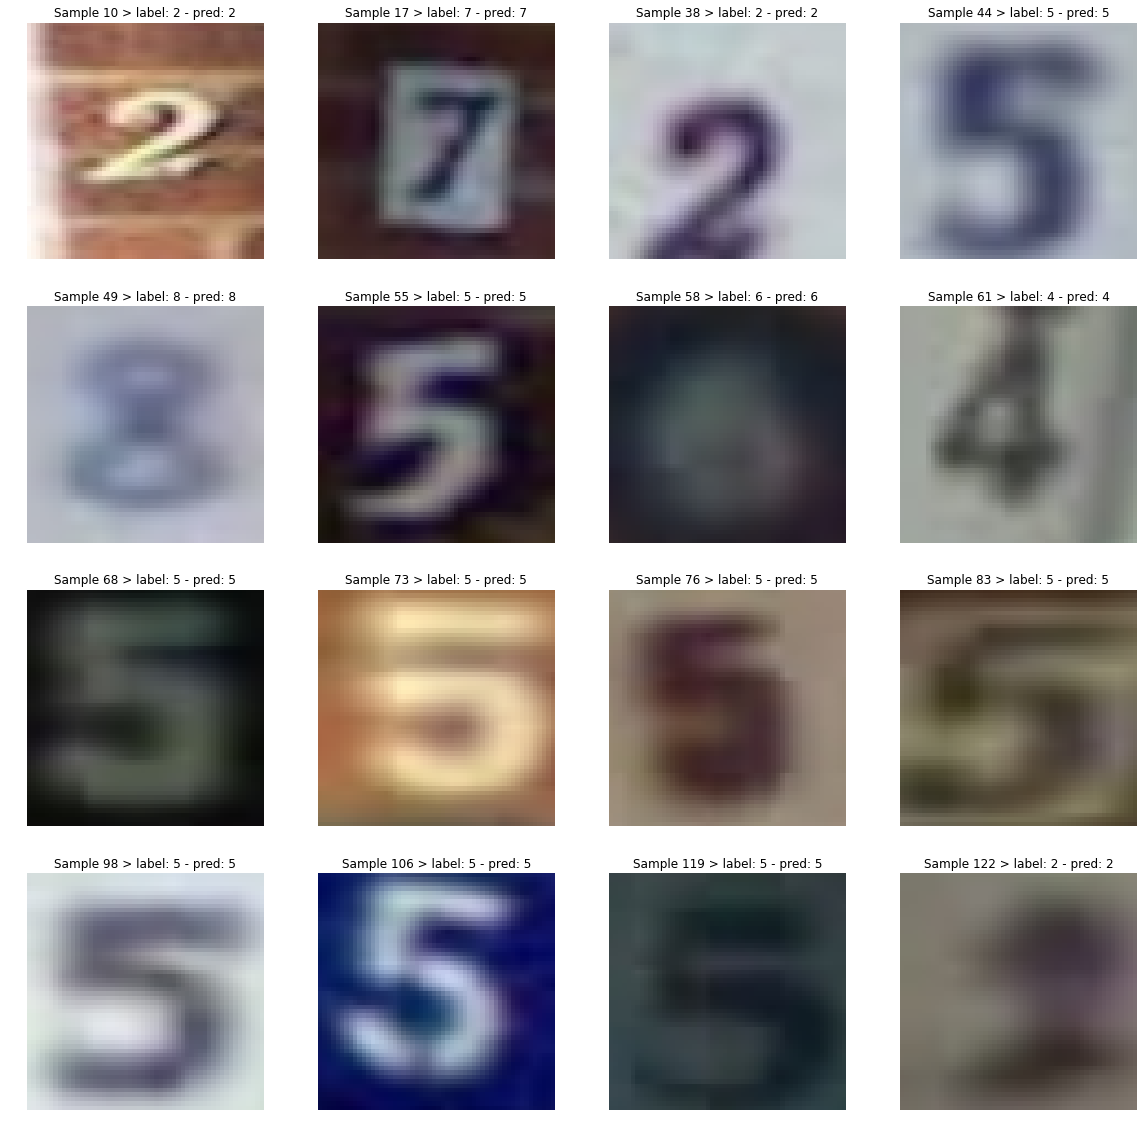

In [38]:
vizResults(dataset_test, correct_sample_idx[0][:16],
           test_length_pred, test_digit_pred, test_length_label, test_digit_label)

#### Resultados corretos para comprimento 2

/home/adriano/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


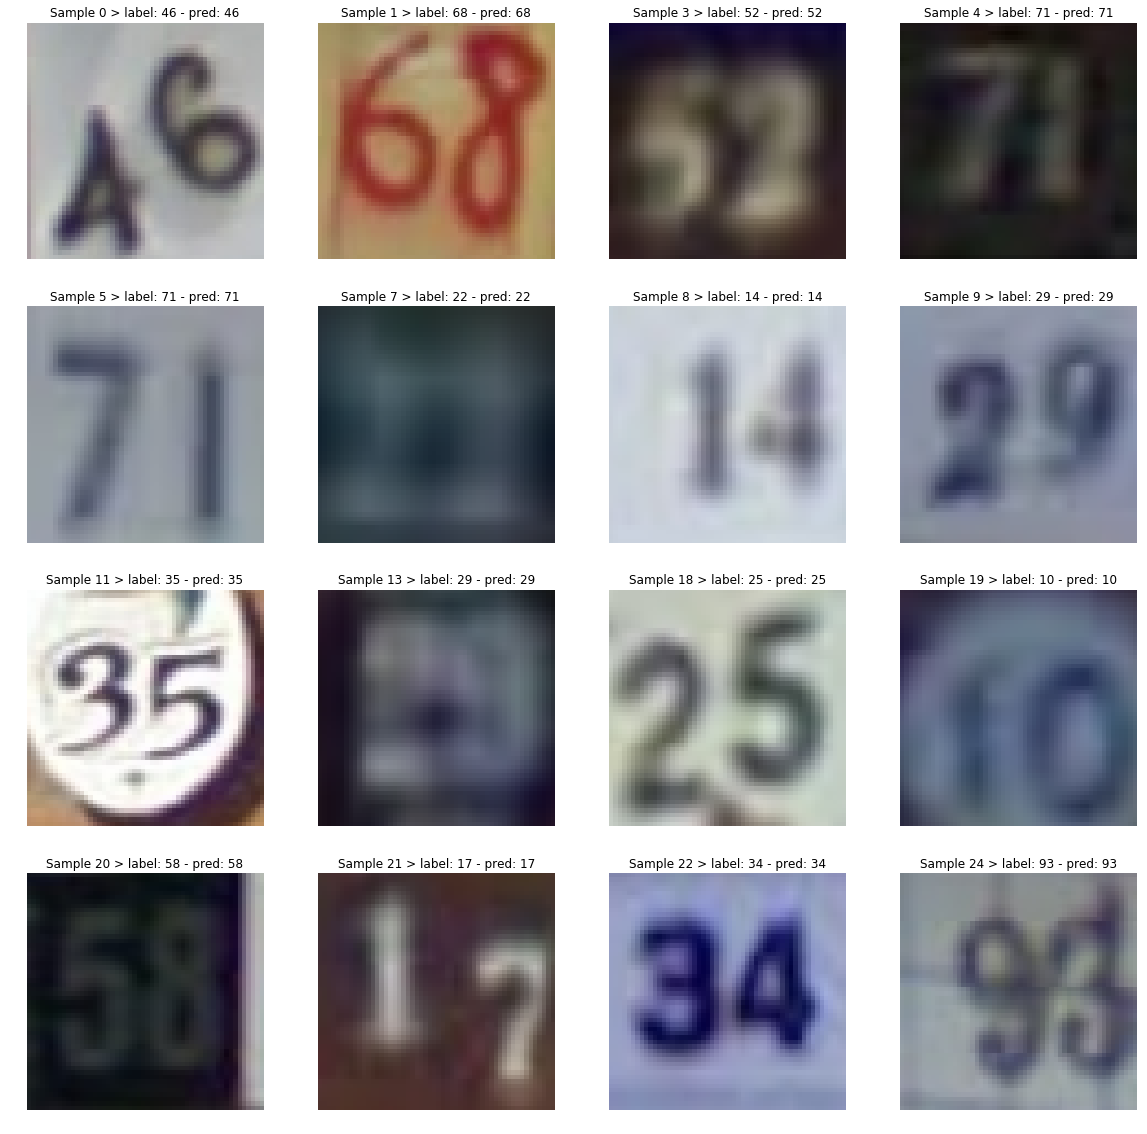

In [39]:
vizResults(dataset_test, correct_sample_idx[1][:16],
           test_length_pred, test_digit_pred, test_length_label, test_digit_label)

#### Resultados corretos para comprimento 3

/home/adriano/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


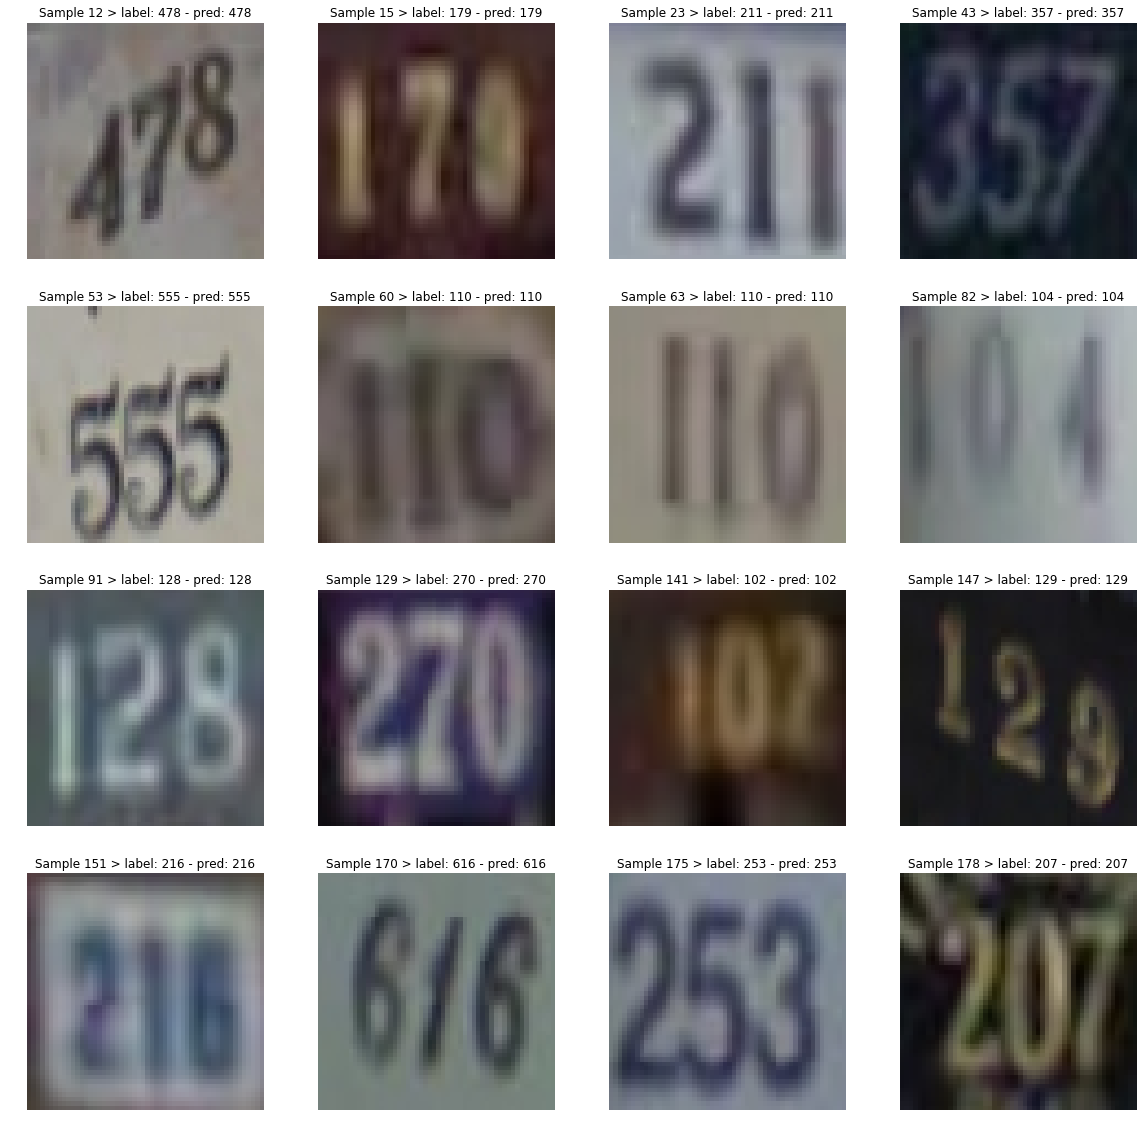

In [40]:
vizResults(dataset_test, correct_sample_idx[2][:16],
           test_length_pred, test_digit_pred, test_length_label, test_digit_label)

#### Resultados corretos para comprimento 4

/home/adriano/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


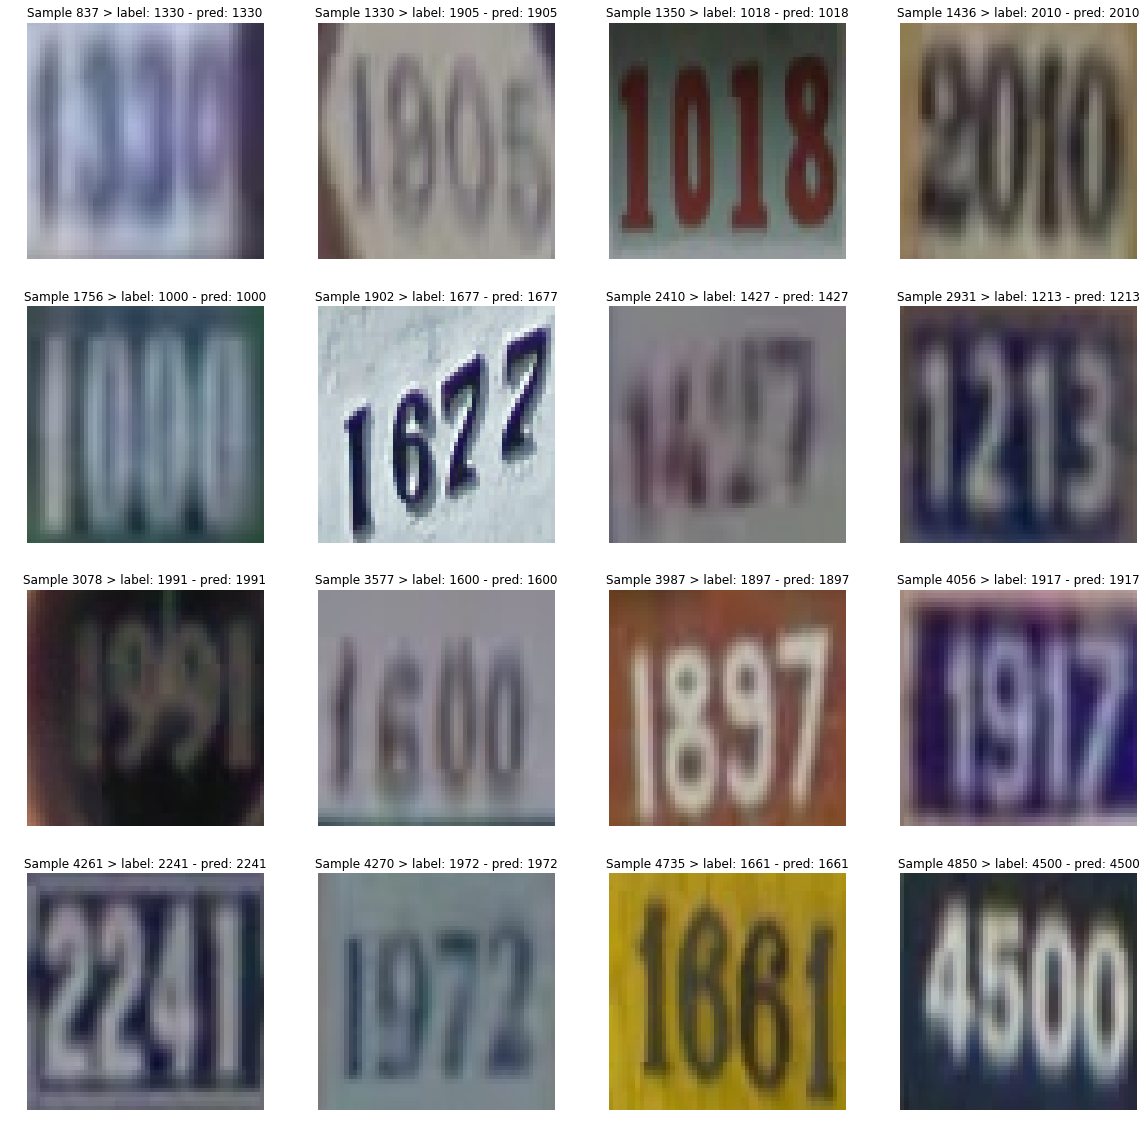

In [41]:
vizResults(dataset_test, correct_sample_idx[3][:16],
           test_length_pred, test_digit_pred, test_length_label, test_digit_label)

#### Resultados errados

/home/adriano/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


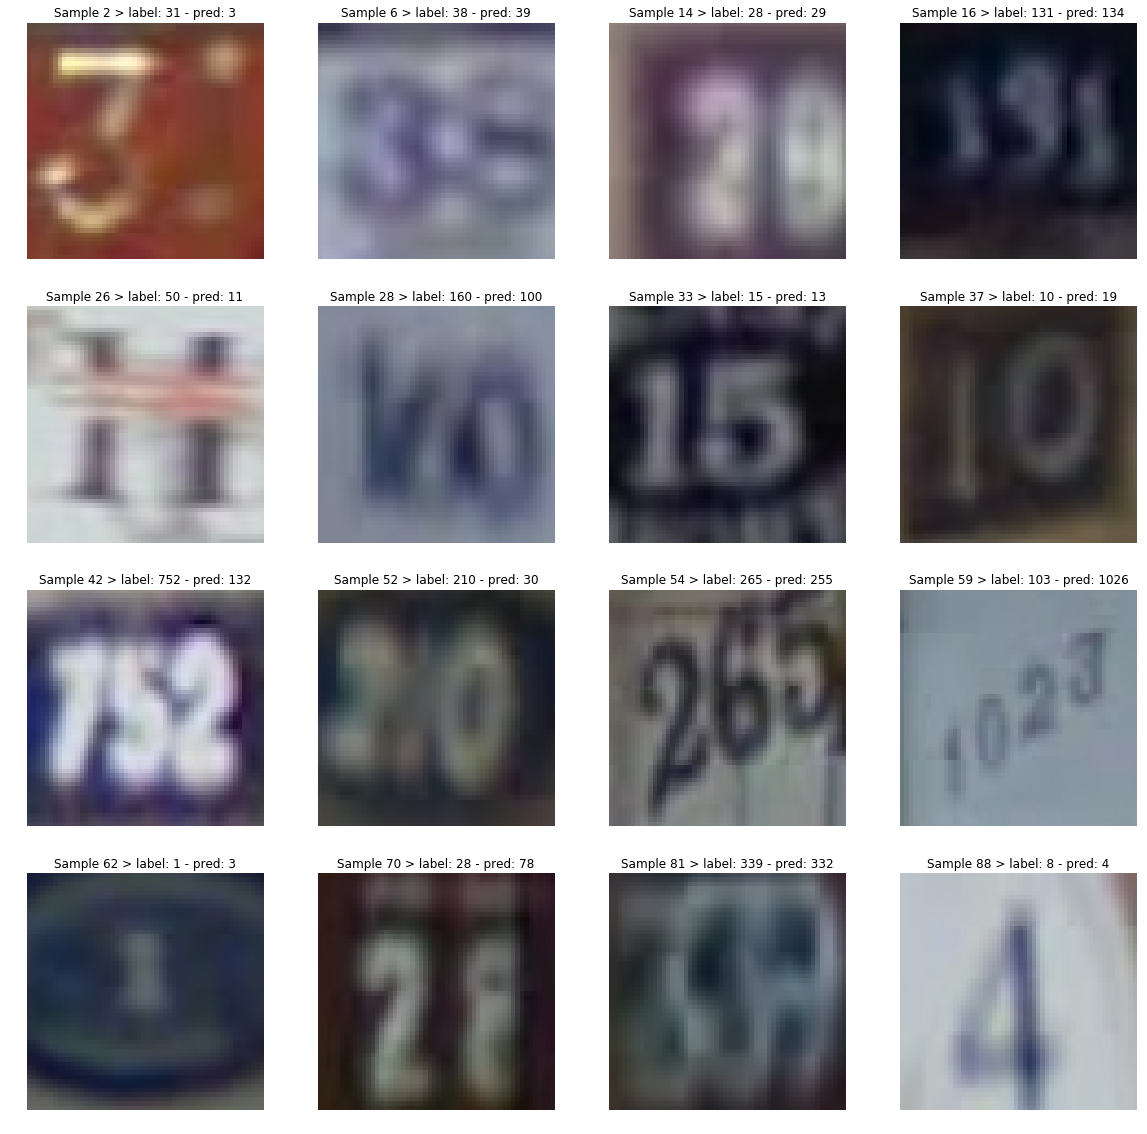

In [42]:
vizResults(dataset_test, wrong_sample_idx[:16],
           test_length_pred, test_digit_pred, test_length_label, test_digit_label)